# 24083010100 - REGRESI LINEAR BERGANDA

# **PREPROCESSING DATA**

In [258]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import jarque_bera, norm

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 100

# 1. LOAD DATA DARI KAGGLE
train_df = pd.read_csv("/kaggle/input/statistika-regresi-sains-data-upnvjt-regresi/train_dataset.csv")
test_df  = pd.read_csv("/kaggle/input/statistika-regresi-sains-data-upnvjt-regresi/test_dataset_no_y.csv")

print("Train shape:", train_df.shape)
print("Test  shape:", test_df.shape)

TARGET   = "y"
cat_cols = ["x2", "x3", "x5", "x6"]
num_cols = ["x1", "x4", "x7", "x8", "x9", "x10"]

Train shape: (800, 11)
Test  shape: (193, 10)


In [259]:
train_df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,y
0,0.407166,E,W,2.0,M,C,1.127628,-0.657689,-0.415323,76.124758,20.710704
1,44.417166,M,W,1.0,H,C,0.957628,-0.667689,-0.475323,85.834758,94.202404
2,28.047166,M,W,4.0,L,R,0.717628,-1.107689,-0.385323,13.814758,43.043004
3,-0.462834,NaN,W,2.0,L,C,1.717628,-1.547689,-0.425323,29.344758,7.956004
4,42.957166,M,W,3.0,M,C,0.747628,-1.847689,-0.135323,NaN,62.397804


In [260]:
test_df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10
0,16.787166,N,W,2.0,L,C,2.807628,-0.687689,-0.175323,103.314758
1,38.137166,M,NaN,1.0,M,C,2.197628,-0.617689,-0.195323,14.644758
2,20.797166,E,W,1.0,M,S,3.007628,-0.687689,-0.235323,41.574758
3,15.577166,A,W,4.0,M,C,0.707628,-0.827689,-0.125323,107.614758
4,44.677166,M,W,4.0,L,C,3.027628,-0.447689,-0.345323,92.434758


In [261]:
print("\nMissing TRAIN:")
print(train_df.isnull().sum())
print("\nMissing TEST:")
print(test_df.isnull().sum())


Missing TRAIN:
x1     43
x2     40
x3     38
x4     36
x5     42
x6     39
x7     39
x8     44
x9     37
x10    42
y      42
dtype: int64

Missing TEST:
x1      7
x2     10
x3     11
x4     13
x5      8
x6     11
x7     10
x8      6
x9     12
x10     8
dtype: int64



[3] Statistik Deskriptif Awal (y)
count    758.000000
mean      53.993730
std       42.823339
min        5.120804
25%       30.710379
50%       45.788304
75%       65.293729
max      328.493593
Name: y, dtype: float64


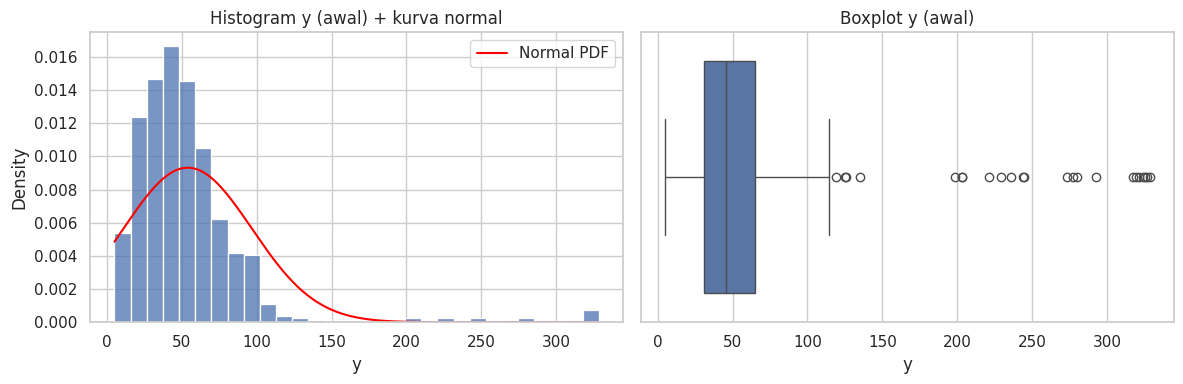

In [262]:
print("\n[3] Statistik Deskriptif Awal (y)")
print(train_df["y"].describe())

y_raw = train_df["y"].dropna()

plt.figure(figsize=(12, 4))

# Histogram y + kurva normal
plt.subplot(1, 2, 1)
ax = sns.histplot(y_raw, kde=False, stat="density", bins=30)
mean_y = y_raw.mean()
std_y  = y_raw.std()
x_vals = np.linspace(y_raw.min(), y_raw.max(), 200)
pdf    = norm.pdf(x_vals, loc=mean_y, scale=std_y)
plt.plot(x_vals, pdf, color="red", label="Normal PDF")
plt.title("Histogram y (awal) + kurva normal")
plt.legend()

# Boxplot y
plt.subplot(1, 2, 2)
sns.boxplot(x=y_raw)
plt.title("Boxplot y (awal)")

plt.tight_layout()
plt.show()


# **DATA CLEANING**

In [263]:
# =====================================================
# 3. DROP BARIS DENGAN y MISSING
# =====================================================
train_df = train_df.dropna(subset=[TARGET]).copy()
print("\nSetelah drop y missing, train shape:", train_df.shape)


Setelah drop y missing, train shape: (758, 11)


In [264]:
train_clean = train_df.copy()
test_clean = test_df.copy()

In [265]:
train_stats = {}

In [266]:
# Imputasi kategori dengan modus
for col in cat_cols:
    if col in train_clean.columns:
        mode_val = train_clean[col].mode()
        if len(mode_val) > 0:
            mode_val = mode_val[0]
            train_stats[f"{col}_mode"] = mode_val
            train_clean[col] = train_clean[col].fillna(mode_val)
            
            # apply ke test (kalau kolomnya ada)
            if col in test_clean.columns:
                test_clean[col] = test_clean[col].fillna(mode_val)

# Imputasi numerik dengan median
for col in num_cols:
    if col in train_clean.columns:
        median_val = train_clean[col].median()
        train_stats[f"{col}_median"] = median_val
        train_clean[col] = train_clean[col].fillna(median_val)
        train_clean[col] = train_clean[col].fillna(median_val)
        if col in test_clean.columns:
            test_clean[col] = test_clean[col].fillna(median_val)

print("Imputasi train + test selesai.")
print("\nImputasi kategori (modus) dan numerik (median) selesai")

Imputasi train + test selesai.

Imputasi kategori (modus) dan numerik (median) selesai


In [267]:
# Trimming outlier y dengan IQR
Q1 = train_clean[TARGET].quantile(0.25)
Q3 = train_clean[TARGET].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outlier_mask = (train_clean[TARGET] < lower) | (train_clean[TARGET] > upper)
n_outliers = outlier_mask.sum()

print(f"\n[4] Deteksi Outlier (IQR 1.5x pada y)")
print(f"    Q1: {Q1:.3f}, Q3: {Q3:.3f}, IQR: {IQR:.3f}")
print(f"    Batas: [{lower:.3f}, {upper:.3f}]")
print(f"    Jumlah outlier: {n_outliers} ({n_outliers/len(train_clean)*100:.2f}%)")

train_clean = train_clean[~outlier_mask].copy()
print(f"    Setelah trimming y: {train_clean.shape[0]} observasi")


[4] Deteksi Outlier (IQR 1.5x pada y)
    Q1: 30.710, Q3: 65.294, IQR: 34.583
    Batas: [-21.165, 117.169]
    Jumlah outlier: 23 (3.03%)
    Setelah trimming y: 735 observasi


In [268]:
X = train_clean.drop(columns=[TARGET])
y = train_clean[TARGET]

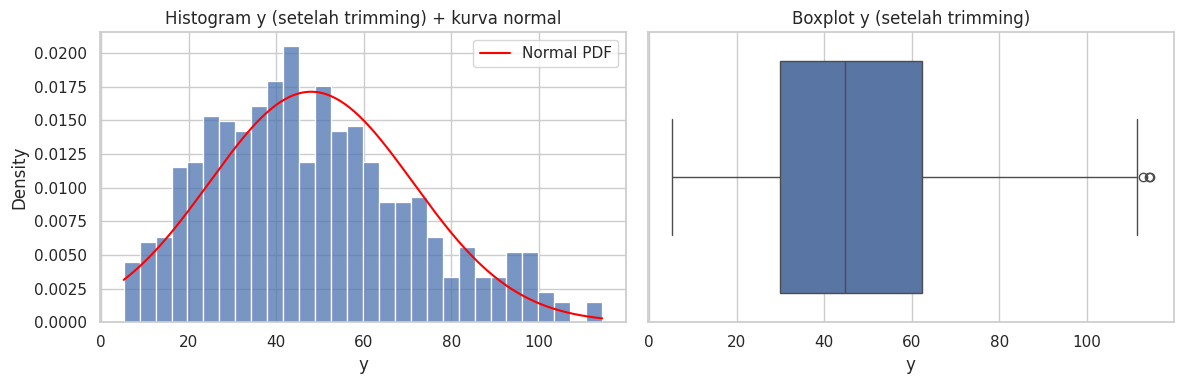

In [269]:
y_trim = train_clean[TARGET]

plt.figure(figsize=(12, 4))

# Histogram y_trim + kurva normal
plt.subplot(1, 2, 1)
ax = sns.histplot(y_trim, kde=False, stat="density", bins=30)
mean_y_t = y_trim.mean()
std_y_t  = y_trim.std()
x_vals   = np.linspace(y_trim.min(), y_trim.max(), 200)
pdf_t    = norm.pdf(x_vals, loc=mean_y_t, scale=std_y_t)
plt.plot(x_vals, pdf_t, color="red", label="Normal PDF")
plt.title("Histogram y (setelah trimming) + kurva normal")
plt.legend()

# Boxplot y_trim
plt.subplot(1, 2, 2)
sns.boxplot(x=y_trim)
plt.title("Boxplot y (setelah trimming)")

plt.tight_layout()
plt.show()


# **ONE - HOT ENCODING**

In [270]:
X_encoded = X_all_enc.iloc[:len(X_clean), :].copy()
X_test_enc = X_all_enc.iloc[len(X_clean):, :].copy()

print("\nShape X_encoded (train):", X_encoded.shape)
print("Shape X_test_enc (test):", X_test_enc.shape)


Shape X_encoded (train): (735, 16)
Shape X_test_enc (test): (193, 16)


In [271]:
print("Daftar kolom yang mengandung 'x1','x8','x9','x10':")
print([c for c in X_encoded.columns if any(v in c for v in ["x1","x8","x9","x10"])])


Daftar kolom yang mengandung 'x1','x8','x9','x10':
['x1', 'x8', 'x9', 'x10']


# **MODEL OLS ROBUST**

In [272]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)
# Ambil hanya variabel signifikan dari data yang sudah dipreproses & di-split
sig_cols = ['x1', 'x8', 'x9', 'x10']  # variabel signifikan dari output OLS robust

# Ensure that sig_cols are present in the one-hot encoded X_train.
# If any of the original categorical columns were part of sig_cols,
# their one-hot encoded versions would be different.
# However, `sig_cols` here only contains numerical columns, so this part should be fine.

X_train_sig = X_train[sig_cols]
X_val_sig   = X_val[sig_cols]

# Tambahkan konstanta
X_train_sig_c = sm.add_constant(X_train_sig)
X_val_sig_c   = sm.add_constant(X_val_sig)

In [273]:
X_train_sig = X_train[sig_cols]
X_val_sig   = X_val[sig_cols]

# Tambahkan konstanta
X_train_sig_c = sm.add_constant(X_train_sig)
X_val_sig_c   = sm.add_constant(X_val_sig)

In [274]:
model_sig = sm.OLS(y_train, X_train_sig_c).fit(cov_type='HC3')

print("="*70)
print("RINGKASAN MODEL OLS ROBUST (VARIABEL SIGNIFIKAN SAJA)")
print("="*70)
print(model_sig.summary())

RINGKASAN MODEL OLS ROBUST (VARIABEL SIGNIFIKAN SAJA)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     826.1
Date:                Wed, 31 Dec 2025   Prob (F-statistic):          1.61e-238
Time:                        16:49:00   Log-Likelihood:                -2093.8
No. Observations:                 588   AIC:                             4198.
Df Residuals:                     583   BIC:                             4219.
Df Model:                           4                                         
Covariance Type:                  HC3                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------

*Model ini sudah sangat baik karena sekitar 86,5% variasi y dapat dijelaskan hanya oleh empat variabel x1, x8, x9, dan x10, dan uji F menunjukkan model signifikan secara keseluruhan. Semua koefisiennya signifikan, dengan pengaruh paling besar berasal dari x9 dan x8, sehingga kedua variabel ini menjadi penentu utama perubahan y.*

In [275]:
# Evaluasi performa
y_train_pred = model_sig.predict(X_train_sig_c)
y_val_pred   = model_sig.predict(X_val_sig_c)

mse_train_sig = mean_squared_error(y_train, y_train_pred)
mse_val_sig   = mean_squared_error(y_val, y_val_pred)
r2_train_sig  = r2_score(y_train, y_train_pred)

print("\nMSE Train (sig only):", mse_train_sig)
print("MSE Val   (sig only):", mse_val_sig)
print("R2 Train  (sig only):", r2_train_sig)


MSE Train (sig only): 72.52137423865898
MSE Val   (sig only): 76.00840382213057
R2 Train  (sig only): 0.865087098733435


In [276]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import jarque_bera

# Asumsi model_sig sudah dibuat seperti sebelumnya (x1, x8, x9, x10)
resid = model_sig.resid
X_sig_train_c = model_sig.model.exog   # desain matrix dengan konstanta


# **UJI NORMALITAS**

In [277]:
jb_stat, jb_pvalue, skew, kurt = jarque_bera(resid)

print("=== UJI NORMALITAS (JARQUE-BERA) ===")
print(f"JB Statistic : {jb_stat:.4f}")
print(f"p-value      : {jb_pvalue:.6f}")
print(f"Skewness     : {skew:.4f}")
print(f"Kurtosis     : {kurt:.4f}")

=== UJI NORMALITAS (JARQUE-BERA) ===
JB Statistic : 86.3447
p-value      : 0.000000
Skewness     : -0.4134
Kurtosis     : 4.6854


*Hasil uji Jarque–Bera menunjukkan bahwa residual tidak berdistribusi normal, karena p-value = 0.000000 jauh di bawah 0,05 sehingga hipotesis nol normalitas residual ditolak. Nilai skewness -0.4134 menandakan residual agak condong ke kiri, sementara kurtosis 4.6854 (>3) menunjukkan distribusi lebih runcing dan berekor lebih berat daripada normal, sehingga ada sedikit penyimpangan dari bentuk normal ideal.*

# **UJI HETEROSKEDASTISITAS**

In [278]:
bp_stat, bp_pvalue, _, _ = het_breuschpagan(resid, X_sig_train_c)

print("\n=== UJI HETEROSKEDASTISITAS (BREUSCH-PAGAN) ===")
print(f"LM Statistic : {bp_stat:.4f}")
print(f"p-value      : {bp_pvalue:.6f}")


=== UJI HETEROSKEDASTISITAS (BREUSCH-PAGAN) ===
LM Statistic : 2.2843
p-value      : 0.683637


*Hasil uji Breusch–Pagan menunjukkan tidak ada indikasi heteroskedastisitas yang signifikan, karena p-value 0.6836 jauh di atas 0.05 sehingga hipotesis nol “varian error konstan (homoskedastis)” tidak dapat ditolak. Artinya, asumsi kesamaan ragam error di sepanjang rentang prediksi model cukup terpenuhi pada data ini.*

# **UJI AUTOKORELASI**

In [279]:
dw_stat = sm.stats.durbin_watson(resid)

print("\n=== UJI AUTOKORELASI (DURBIN-WATSON) ===")
print(f"DW Statistic : {dw_stat:.4f}")


=== UJI AUTOKORELASI (DURBIN-WATSON) ===
DW Statistic : 2.0263


*Nilai Durbin–Watson sekitar 2.03 sangat dekat dengan 2, yang mengindikasikan tidak terdapat autokorelasi yang signifikan pada residual, baik positif maupun negatif. Dengan demikian, asumsi bahwa error bersifat independen terhadap satu sama lain dapat dianggap terpenuhi untuk model ini.*

# **UJI MULTIKOLINEARITAS**

In [280]:
import pandas as pd

X_for_vif = pd.DataFrame(X_sig_train_c, columns=model_sig.model.exog_names)
X_for_vif = X_for_vif.drop(columns=['const'])

vif_data = []
for i, col in enumerate(X_for_vif.columns):
    vif_data.append((col, variance_inflation_factor(X_for_vif.values, i)))

vif_df = pd.DataFrame(vif_data, columns=['Variable','VIF'])
print("\n=== VIF (MULTIKOLINEARITAS) ===")
print(vif_df)


=== VIF (MULTIKOLINEARITAS) ===
  Variable       VIF
0       x1  3.360384
1       x8  6.475876
2       x9  6.537905
3      x10  4.028888


*Nilai VIF untuk semua variabel masih di bawah 10, sehingga tidak ada masalah multikolinearitas yang berat pada model. x8 dan x9 memiliki VIF sekitar 6,5 yang menunjukkan ada korelasi sedang hingga kuat dengan prediktor lain, tetapi masih dalam batas yang umumnya dapat diterima untuk analisis regresi.*

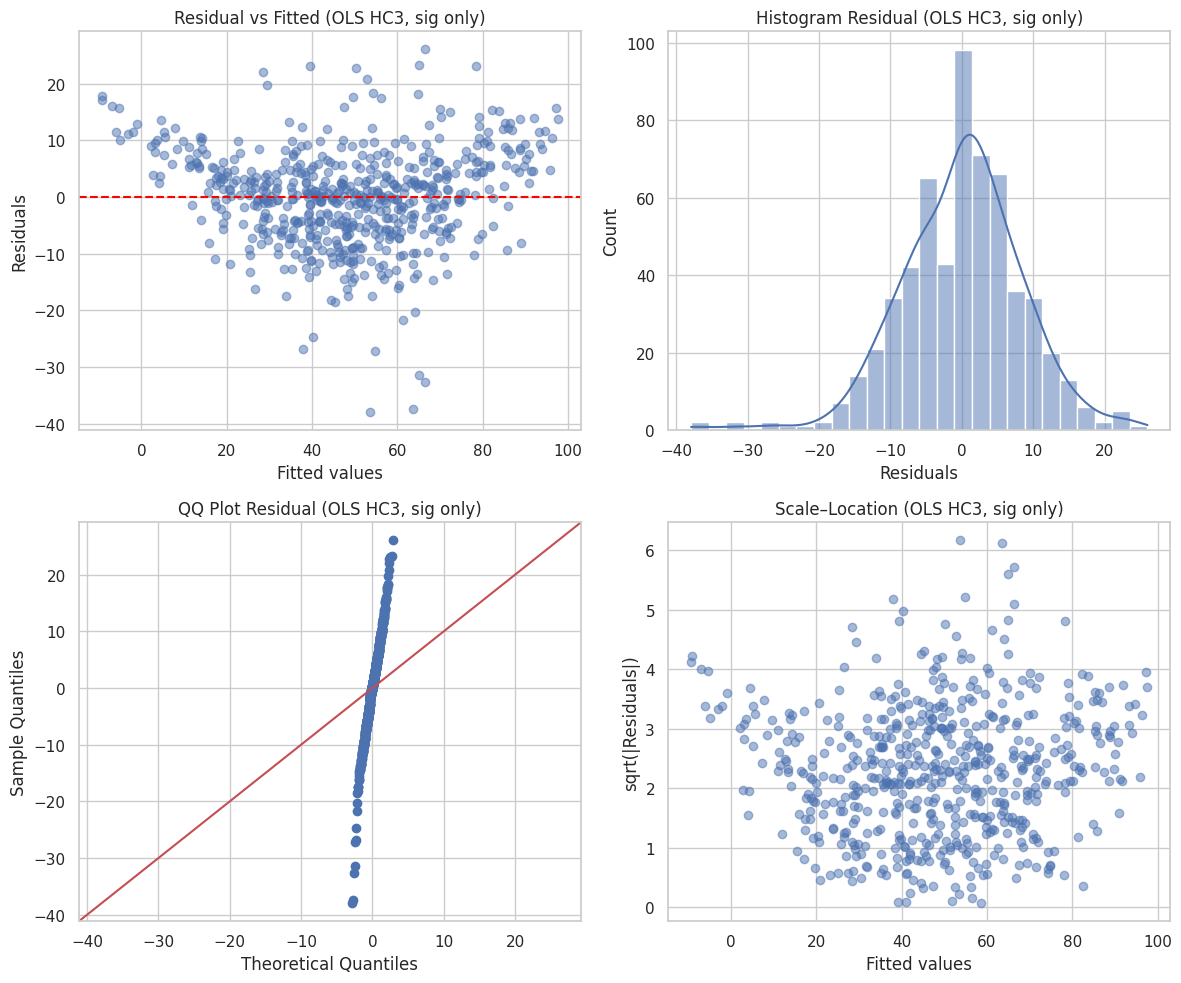

In [281]:
# =====================================================
# VISUALISASI RESIDUAL MODEL OLS ROBUST HC3 (SIG ONLY)
# =====================================================
resid_hc3  = model_sig.resid
fitted_hc3 = model_sig.fittedvalues

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1) Residual vs Fitted
axes[0,0].scatter(fitted_hc3, resid_hc3, alpha=0.5)
axes[0,0].axhline(0, color='red', linestyle='--')
axes[0,0].set_xlabel("Fitted values")
axes[0,0].set_ylabel("Residuals")
axes[0,0].set_title("Residual vs Fitted (OLS HC3, sig only)")

# 2) Histogram residual + KDE
sns.histplot(resid_hc3, kde=True, ax=axes[0,1])
axes[0,1].set_xlabel("Residuals")
axes[0,1].set_title("Histogram Residual (OLS HC3, sig only)")

# 3) QQ Plot
sm.qqplot(resid_hc3, line='45', ax=axes[1,0])
axes[1,0].set_title("QQ Plot Residual (OLS HC3, sig only)")

# 4) Scale–Location (Spread vs Fitted)
axes[1,1].scatter(fitted_hc3, np.sqrt(np.abs(resid_hc3)), alpha=0.5)
axes[1,1].set_xlabel("Fitted values")
axes[1,1].set_ylabel("sqrt(|Residuals|)")
axes[1,1].set_title("Scale–Location (OLS HC3, sig only)")

plt.tight_layout()
plt.show()

In [282]:
# Fit final dengan seluruh train_clean
X_full_sig = train_clean[sig_cols]
y_full     = train_clean[TARGET]
X_full_sig_c = sm.add_constant(X_full_sig)

model_sig_full = sm.OLS(y_full, X_full_sig_c).fit(cov_type='HC3')

# Siapkan test_clean dengan kolom yang sama
X_test_sig   = test_clean[sig_cols]
X_test_sig_c = sm.add_constant(X_test_sig)

y_test_pred = model_sig_full.predict(X_test_sig_c)

In [283]:
submission = pd.DataFrame({
    "ID": np.arange(1, len(y_test_pred) + 1),  # atau test_raw["ID"] jika ada
    "y": y_test_pred
})

submission.to_csv("submission_model_sig_clean.csv", index=False)
print("File submission_model_sig_clean.csv berhasil dibuat.")

File submission_model_sig_clean.csv berhasil dibuat.


In [284]:
submission.head(10)

,ID,y
0,1,73.894445
1,2,75.693553
2,3,57.963543
3,4,73.172244
4,5,101.129873
5,6,57.028900
6,7,20.855941
7,8,39.998360
8,9,34.676799
9,10,70.936949
